# Coursework for Artificial Intelligence H COMPSCI4004 2024-2025

## Imports

In [1]:
import os, sys
import networkx as nx
from mazelib import Maze
from mazelib.generate.Prims import Prims
import numpy as np
import random as rand

import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

print("Python version:", sys.version)
print("Networkx version:", nx.__version__)
print("IPyWidgets version:", widgets.__version__)

Python version: 3.13.0 | packaged by Anaconda, Inc. | (main, Oct  7 2024, 21:29:38) [GCC 11.2.0]
Networkx version: 3.4.2
IPyWidgets version: 8.1.5


In [2]:
# To import the AIMA toolbox, add path the to the AIMA Python Toolbox folder on your system
AIMA_TOOLBOX_ROOT="/home/valeria/Documents/Code/aima-python-uofg_v20202021a"
sys.path.append(AIMA_TOOLBOX_ROOT)

import search as sch
from notebookutils import show_map, display_visual
# Needed to hide warnings in the matplotlib sections

## Parameters

In [3]:
N = 9 # Number of tiles on the side
M = 3 # Number of wormholes

In [4]:
# Maze will have shape (N,N) counting walls ==> N needs to be an odd number
assert N % 2 == 1, "N needs to be an odd number"
# Entrance and exit are in the walls

## Maze Generation

### Generate a random maze

In [5]:
# rand.seed(32)

In [6]:
m = Maze( )
m.generator = Prims(int(N/2), int(N/2))
m.generate()
m.generate_entrances(True, True)
print(m)
print(len(m.grid))

#########
# #   # #
# # ### #
S   # # E
### # # #
#     # #
# # ### #
# #     #
#########
9


In [7]:
m.grid

array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int8)

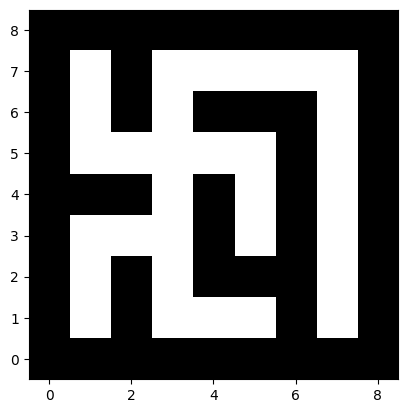

In [8]:
plt.imshow(np.logical_not(m.grid), cmap="gray", origin="lower")

### Get a grid with entrance and exit

In [9]:
maze_grid = np.logical_not(m.grid)*2
maze_grid[m.start] = 1
maze_grid[m.end] = 3
maze_grid = maze_grid.astype(np.uint8)
# Probably won't be able to have more than 2**8-3 wormholes

n = len(maze_grid)

In [10]:
maze_grid

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 2, 2, 2, 0, 2, 0],
       [0, 2, 0, 2, 0, 0, 0, 2, 0],
       [1, 2, 2, 2, 0, 2, 0, 2, 3],
       [0, 0, 0, 2, 0, 2, 0, 2, 0],
       [0, 2, 2, 2, 2, 2, 0, 2, 0],
       [0, 2, 0, 2, 0, 0, 0, 2, 0],
       [0, 2, 0, 2, 2, 2, 2, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

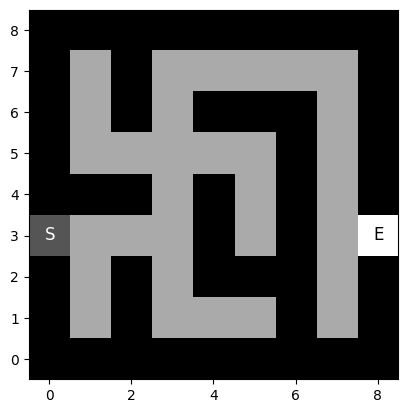

In [11]:
plt.imshow(maze_grid, cmap="gray", origin="lower")
for (j, i), label, color in zip([m.start, m.end], ["S","E"], ["w", "k"]):
    plt.text(i-.1, j-.1, label, color=color, fontsize="large")

### Generate wormholes

#### Some helper functions

In [12]:
def square2flat(i, j, N):
    """From indices in a square array, to index in flatten array"""
    return i*N + j

def flat2square(k, N):
    """From indices in a flatten array, to index in square array"""
    return (k // N, k % N)

def square_neighbours(k, N):
    """Return neighbours in a squared array while working with flatten indices"""
    i, j = flat2square(k, N)
    neighbours = []
    if i>0: neighbours.append(k-N)
    if i<N-1: neighbours.append(k+N)
    if j>0: neighbours.append(k-1)
    if j<N-1: neighbours.append(k+1)
    return neighbours    

In [13]:
index = square2flat(8,8,N)

print("Flat index", index)
print("Square array indices", flat2square(index, N))
print("Neighbours' flat indices", square_neighbours(index, N))
print("Neighbours' square indices", [flat2square(k, N) for k in square_neighbours(index, N)])

Flat index 80
Square array indices (8, 8)
Neighbours' flat indices [71, 79]
Neighbours' square indices [(7, 8), (8, 7)]


#### Wormhole indices selection

In [14]:
# Available tiles for wormhole entrances
indices_available = np.where(maze_grid.flatten()==2)[0].tolist()
n_available = len(indices_available)
assert n_available >= 2*M, "Not enough empty tiles for that many wormholes"


In [15]:
# Randomize positions
rand.shuffle(indices_available)

# Make sure that wormholes are not formed between neighbours
wormholes = []
filled = False
while not filled:
    if len(wormholes)%2 == 0:
        add_candidate = True
    else:
        if indices_available[0] not in square_neighbours(index, wormholes[-1]):
            add_candidate = True
        else: add_candidate = False
    if add_candidate:
        wormholes.append( indices_available.pop(0) )
    else:
        indices_available.append( indices_available.pop(0) )
    filled = len(wormholes) == 2*M

In [16]:
wormholes

[47, 28, 32, 14, 41, 67]

In [17]:
[flat2square(w_k, N) for w_k in wormholes]

[(5, 2), (3, 1), (3, 5), (1, 5), (4, 5), (7, 4)]

### Visualization

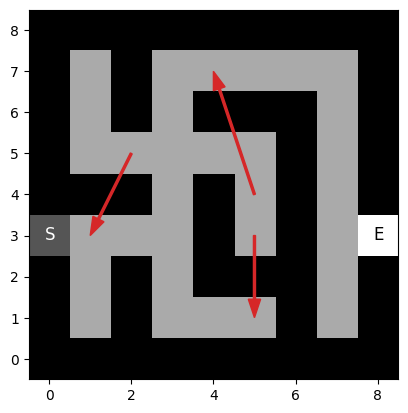

In [18]:
plt.imshow(maze_grid, cmap="gray", origin="lower")
for w_k in range(M):
    i_start, j_start = flat2square(wormholes[2*w_k], N)
    i_end, j_end = flat2square(wormholes[2*w_k+1], N)
    plt.arrow(j_start, i_start, j_end-j_start, i_end-i_start,
              width=0.05, head_width=0.3, length_includes_head=True,
              color="C3")
for (j, i), label, color in zip([m.start, m.end], ["S","E"], ["w", "k"]):
    plt.text(i-.1, j-.1, label, color=color, fontsize="large")

### Graph representation of the maze

In [19]:
tile2str = lambda i, j : f"S_{i:02d}_{j:02d}"

In [20]:
network_dict = {}
map_locations = {}
for i in range(N):
    for j in range(N):
        if maze_grid[i,j]: 
            cell_dict = {}
            if i>0 and maze_grid[i-1,j]: cell_dict[ tile2str(j,i-1) ] = 1
            if i<N-1 and maze_grid[i+1,j]: cell_dict[ tile2str(j,i+1) ] = 1
            if j>0 and maze_grid[i,j-1]: cell_dict[ tile2str(j-1,i) ] = 1
            if j<N-1 and maze_grid[i,j+1]: cell_dict[ tile2str(j+1,i) ] = 1
            network_dict[ tile2str(j,i) ] = cell_dict
            map_locations[ tile2str(j,i) ] = (j,i)

maze_start = tile2str(*m.start[::-1])
maze_end = tile2str(*m.end[::-1])

In [21]:
if M>0:
    for w_k in range(M):
        i_start, j_start = flat2square(wormholes[2*w_k], N)
        i_end, j_end = flat2square(wormholes[2*w_k+1], N)
        network_dict[ tile2str(j_start,i_start) ][ tile2str(j_end,i_end) ] = 1

In [22]:
network_dict

{'S_01_01': {'S_01_02': 1},
 'S_03_01': {'S_03_02': 1, 'S_04_01': 1},
 'S_04_01': {'S_03_01': 1, 'S_05_01': 1},
 'S_05_01': {'S_04_01': 1},
 'S_07_01': {'S_07_02': 1},
 'S_01_02': {'S_01_01': 1, 'S_01_03': 1},
 'S_03_02': {'S_03_01': 1, 'S_03_03': 1},
 'S_07_02': {'S_07_01': 1, 'S_07_03': 1},
 'S_00_03': {'S_01_03': 1},
 'S_01_03': {'S_01_02': 1, 'S_00_03': 1, 'S_02_03': 1},
 'S_02_03': {'S_01_03': 1, 'S_03_03': 1},
 'S_03_03': {'S_03_02': 1, 'S_03_04': 1, 'S_02_03': 1},
 'S_05_03': {'S_05_04': 1, 'S_05_01': 1},
 'S_07_03': {'S_07_02': 1, 'S_07_04': 1, 'S_08_03': 1},
 'S_08_03': {'S_07_03': 1},
 'S_03_04': {'S_03_03': 1, 'S_03_05': 1},
 'S_05_04': {'S_05_03': 1, 'S_05_05': 1, 'S_04_07': 1},
 'S_07_04': {'S_07_03': 1, 'S_07_05': 1},
 'S_01_05': {'S_01_06': 1, 'S_02_05': 1},
 'S_02_05': {'S_01_05': 1, 'S_03_05': 1, 'S_01_03': 1},
 'S_03_05': {'S_03_04': 1, 'S_03_06': 1, 'S_02_05': 1, 'S_04_05': 1},
 'S_04_05': {'S_03_05': 1, 'S_05_05': 1},
 'S_05_05': {'S_05_04': 1, 'S_04_05': 1},
 'S_07

In [23]:
map_locations

{'S_01_01': (1, 1),
 'S_03_01': (3, 1),
 'S_04_01': (4, 1),
 'S_05_01': (5, 1),
 'S_07_01': (7, 1),
 'S_01_02': (1, 2),
 'S_03_02': (3, 2),
 'S_07_02': (7, 2),
 'S_00_03': (0, 3),
 'S_01_03': (1, 3),
 'S_02_03': (2, 3),
 'S_03_03': (3, 3),
 'S_05_03': (5, 3),
 'S_07_03': (7, 3),
 'S_08_03': (8, 3),
 'S_03_04': (3, 4),
 'S_05_04': (5, 4),
 'S_07_04': (7, 4),
 'S_01_05': (1, 5),
 'S_02_05': (2, 5),
 'S_03_05': (3, 5),
 'S_04_05': (4, 5),
 'S_05_05': (5, 5),
 'S_07_05': (7, 5),
 'S_01_06': (1, 6),
 'S_03_06': (3, 6),
 'S_07_06': (7, 6),
 'S_01_07': (1, 7),
 'S_03_07': (3, 7),
 'S_04_07': (4, 7),
 'S_05_07': (5, 7),
 'S_06_07': (6, 7),
 'S_07_07': (7, 7)}

In [24]:
teleportation_links = []
for w_ij in wormholes:
    i, j = flat2square(w_ij, N)
    teleportation_links.append( tile2str(j,i) )

In [25]:
teleportation_links

['S_02_05', 'S_01_03', 'S_05_03', 'S_05_01', 'S_05_04', 'S_04_07']

Important personal interpretation
- I am assuming that going down a teleportation link is optional: e.g. in (2,1) it's possible to go right, go left, or go down the teleportation link.
- I am assuming that the wormholes are two-ways passages: e.g. from (2,1) you can go down the teleportation link to (0,7), and from (0,7) you can go back to (2,1).


- Environment? Besides being discrete and static, it is...
    - Deterministic, because wormholes might lead to an unknown state, but they always lead to the same state with 100% probability.
    - Partially observable, because it is not known from the percepts where the "teleport" action is going to take the agent.
- Actuators? Move the agent according to 5 possible actions:
    - Left
    - Right
    - Up
    - Down
    - Teleport
- Percepts? 
    - Current x,y location
    - Feasibility of all 5 actions, expressed by booleans (l,r,u,d,t)
- Sensors? Incomplete because...
    - The agent knows to which state the (Left, Right, Up, Down) actions take it
    - But the agent does not know to which state the (Teleport) action takes it
- Performance measure? The sortest the path to goal, the better (in terms of steps taken from the start point)

In [26]:
maze_map = sch.Graph(network_dict)
maze_map.locations = map_locations

In [27]:
print("Unique states/nodes (i.e.locations) and possible actions in those states:\n") 
print(maze_map.locations) 

Unique states/nodes (i.e.locations) and possible actions in those states:

{'S_01_01': (1, 1), 'S_03_01': (3, 1), 'S_04_01': (4, 1), 'S_05_01': (5, 1), 'S_07_01': (7, 1), 'S_01_02': (1, 2), 'S_03_02': (3, 2), 'S_07_02': (7, 2), 'S_00_03': (0, 3), 'S_01_03': (1, 3), 'S_02_03': (2, 3), 'S_03_03': (3, 3), 'S_05_03': (5, 3), 'S_07_03': (7, 3), 'S_08_03': (8, 3), 'S_03_04': (3, 4), 'S_05_04': (5, 4), 'S_07_04': (7, 4), 'S_01_05': (1, 5), 'S_02_05': (2, 5), 'S_03_05': (3, 5), 'S_04_05': (4, 5), 'S_05_05': (5, 5), 'S_07_05': (7, 5), 'S_01_06': (1, 6), 'S_03_06': (3, 6), 'S_07_06': (7, 6), 'S_01_07': (1, 7), 'S_03_07': (3, 7), 'S_04_07': (4, 7), 'S_05_07': (5, 7), 'S_06_07': (6, 7), 'S_07_07': (7, 7)}


#### Visualization

In [28]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in maze_map.locations.keys()}
node_positions = maze_map.locations
node_label_pos = { k:[v[0],v[1]-.3]  for k,v in maze_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in maze_map.graph_dict.items() for k2, v2 in v.items()}

maze_graph_data = {  'graph_dict' : maze_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                        'edge_weights': edge_weights
                     }

print("Done creating the graph object")

Done creating the graph object


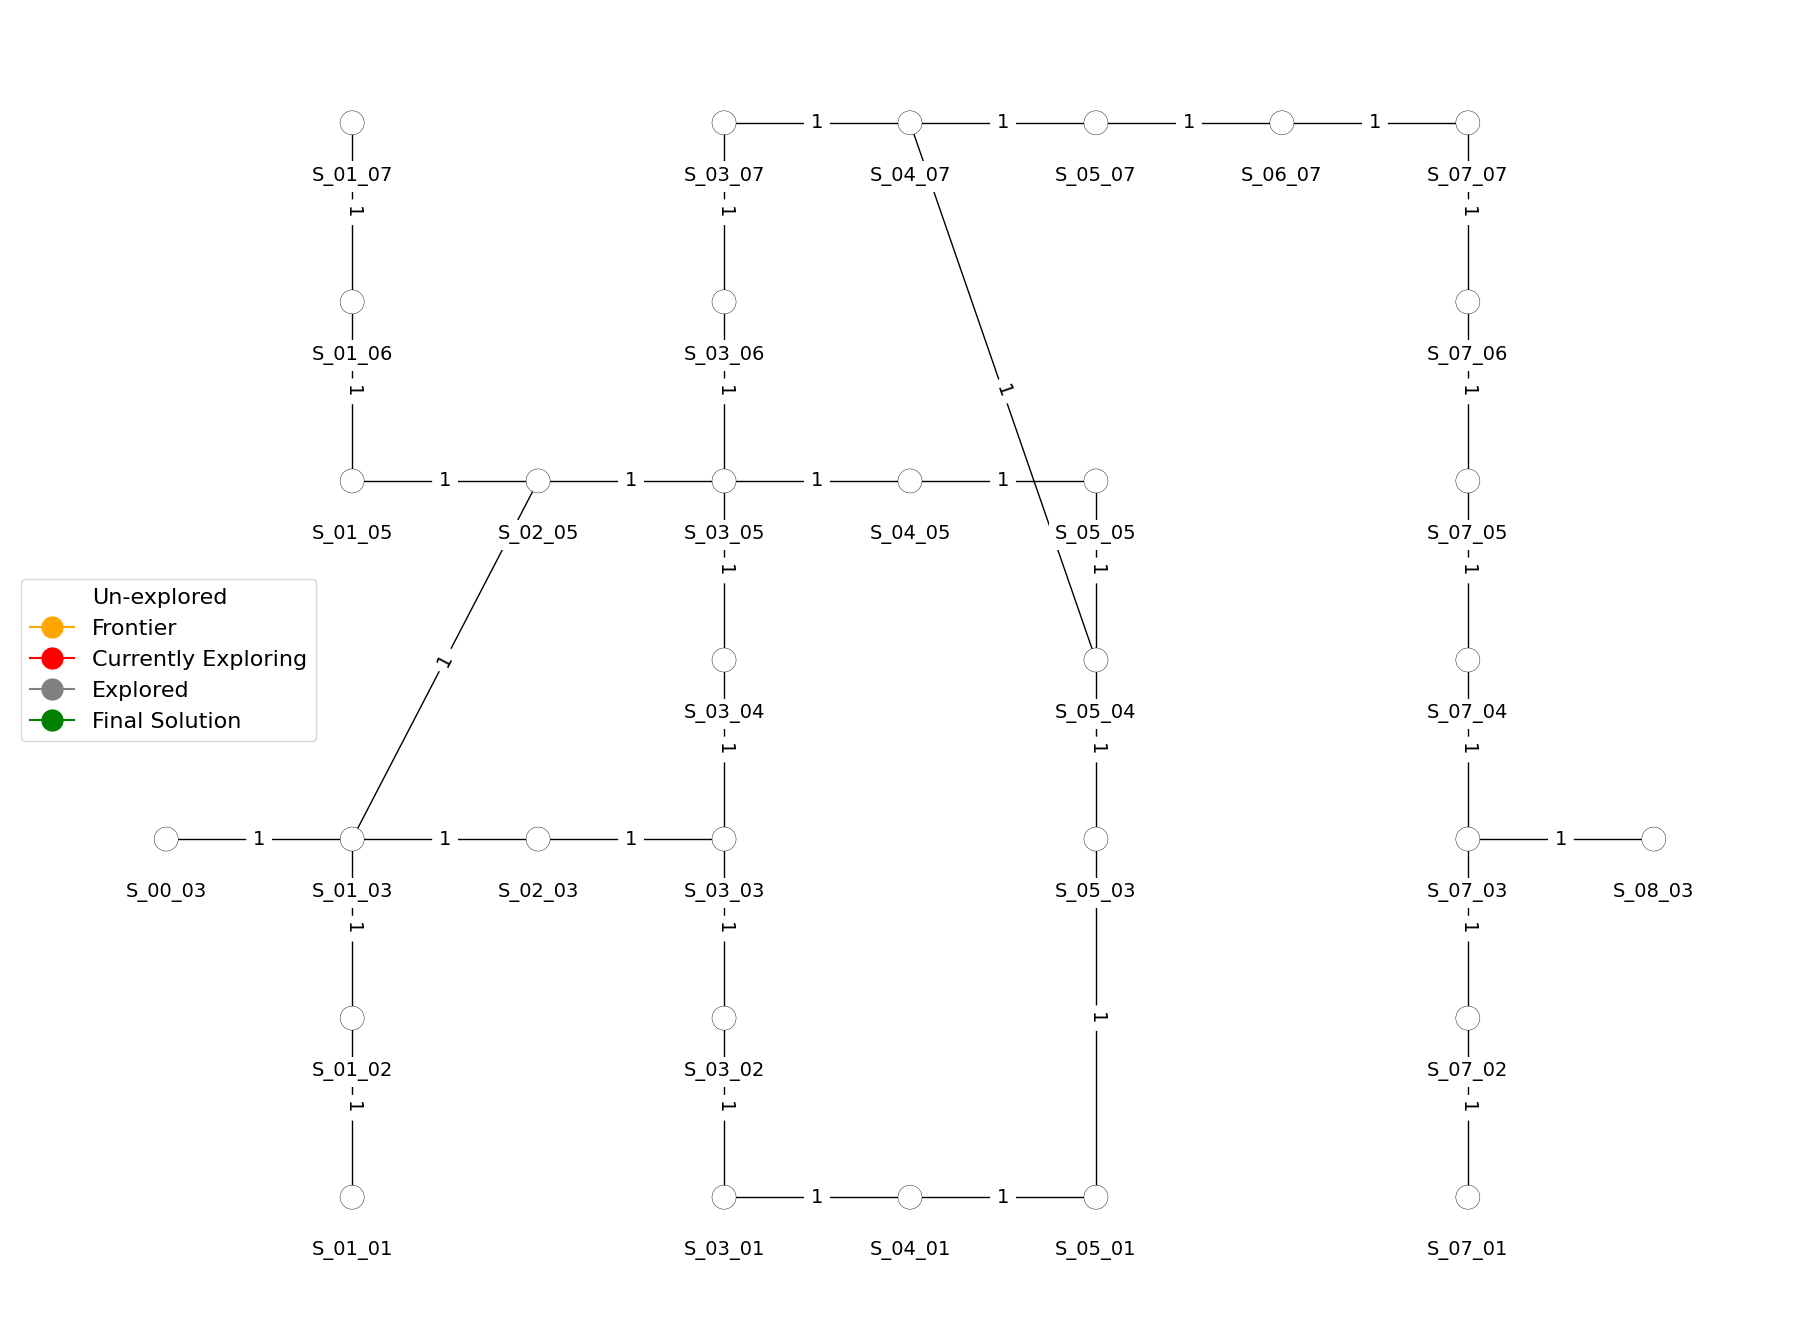

In [29]:
show_map(maze_graph_data)

## Solving the problem

### Define the problem with no knowledge of the wormholes' exit

The A-star algorithm will always reach optimal solution if the heuristic function is admissible. Meaning...

**Complete this**

An agent at the start of a teleportation link can choose to go down the wormhole.
However, it cannot know in advance where the exit is.

The most optimistic case going down a wormhole will always assume that a wormhole can take you right to the exit.

In [ ]:
class WormholesGraphProblem(sch.GraphProblem):
    """The problem of searching a graph with teleportation links.
    
    An agent at the start of a teleportation link can choose to go down the wormhole.
    However, it cannot know in advance where the exit is.
    """

    def __init__(self, start, end, map, wormholes, verbose=False):
        super().__init__(start, end, map)
        self.wormholes = wormholes
        self.verbose = verbose

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def h(self, node, parent=None):
        """The sum of the horizontal and vertical distance to the goal"""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is not str:
                node = node.state
            if parent and type(parent) is not str:
                parent = parent.state
            position_node = np.array(locs[node])
            position_goal = np.array(locs[self.goal])
            if self.verbose: print("Node position", position_node)
            # The most optimistic assumption is that a wormhole will take you right adjacent to the goal
            if parent and node in self.wormholes:
                index = self.wormholes.index(node)
                if index>0 and parent==self.wormholes[index-1]:
                    if self.verbose: print("Teleportation link")
                    return 1 
            if self.verbose: 
                print("Distance to the goal", int( np.sum( np.abs( position_goal - position_node) ) ))
            return int( np.sum( np.abs( position_goal - position_node) ) )
        else:
            return sch.infinity

In [33]:
maze_problem = WormholesGraphProblem(maze_start, maze_end, maze_map, teleportation_links, verbose=True)

print("Initial state:", maze_problem.initial)
print("Goal state:", maze_problem.goal)
print("Teleportation links:", maze_problem.wormholes)

Initial state: S_00_03
Goal state: S_08_03
Teleportation links: ['S_02_05', 'S_01_03', 'S_05_03', 'S_05_01', 'S_05_04', 'S_04_07']


In [34]:
maze_problem.h(*maze_problem.wormholes[:2][::-1])

Node position [1 3]
Teleportation link


1

### Generalize A-star

In [35]:
import heapq
from aimautils import PriorityQueue

class MyPriorityQueue(PriorityQueue):
    """A Queue in which elements are returned ordered according to f.
    
    If order is 'min', the item with minimum f(x) is returned first; if order is 
    'max', then it is the item with maximum f(x). Also supports dict-like lookup.

    In contrast with AIMA's implementation, f can take optional arguments
    """

    def append(self, item, *args):
        """Insert item at its correct position."""
        heapq.heappush(self.heap, (self.f(item, *args), item))

    def extend(self, items):
        raise NotImplementedError

    def pop(self):
        """Pop and return the item (with min or max f(x) value
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, item):
        """Return True if item in PriorityQueue."""
        keys = [k for (_, k) in self.heap]
        return item in keys

    def __getitem__(self, key, *args):
        for _, item in self.heap:
            if item == key:
                return item

    def get_full_item(self, key):
        for _, item in self.heap:
            if item == key:
                return (_, item)

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        keys = [k for (_, k) in self.heap]
        index = keys.index(key)
        self.heap.remove(self.heap[index])
        heapq.heapify(self.heap)

In [36]:
def A_star_solver(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = sch.memoize(f, 'f')
    node = sch.Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "limegreen"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = MyPriorityQueue('min', f)
    frontier.append(node, None)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "limegreen"
            node_colors[problem.initial] = "limegreen"
            for extra_node in node.solution():
                node_colors[extra_node] = "limegreen"  
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child, node)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                current_f, incumbent = frontier.get_full_item(child)
                if problem.verbose: print("Incumbent", incumbent)
                if f(child, node) < current_f:
                    del frontier[incumbent]
                    frontier.append(child, node)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [37]:
def my_A_star_solver(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    h = sch.memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = A_star_solver(
        problem, lambda node, parent : node.path_cost + h(node, parent)
    )
    return(iterations, all_node_colors, node)

### Run the solver

In [38]:
all_node_colors=[]
iterations, all_node_colors, node = my_A_star_solver(problem=maze_problem, h=None)

#-- Trace the solution --#
solution_path = [node]
cnode = node.parent
solution_path.append(cnode)
while cnode.state != maze_start:
    cnode = cnode.parent  
    solution_path.append(cnode)

print("----------------------------------------")
print("Identified goal state:"+str(solution_path[0]))
print("----------------------------------------")
print("Solution trace:"+str(solution_path))
print("----------------------------------------")


Node position [0 3]
Distance to the goal 8
Node position [1 3]
Distance to the goal 7
Node position [1 2]
Distance to the goal 8
Node position [2 3]
Distance to the goal 6
Node position [3 3]
Distance to the goal 5
Node position [3 2]
Distance to the goal 6
Node position [3 4]
Distance to the goal 6
Node position [1 1]
Distance to the goal 9
Node position [3 1]
Distance to the goal 7
Node position [3 5]
Distance to the goal 7
Node position [4 1]
Distance to the goal 6
Node position [3 6]
Distance to the goal 8
Node position [2 5]
Distance to the goal 8
Node position [4 5]
Distance to the goal 6
Node position [5 1]
Distance to the goal 5
Node position [5 5]
Distance to the goal 5
Node position [5 4]
Distance to the goal 4
Node position [5 3]
Distance to the goal 3
Node position [4 7]
Teleportation link
Node position [3 7]
Distance to the goal 9
Node position [5 7]
Distance to the goal 7
Node position [1 5]
Distance to the goal 9
Incumbent <Node S_03_07>
Node position [3 7]
Distance to t

In [39]:
all_node_colors

[{'S_02_03': 'white',
  'S_08_03': 'white',
  'S_07_05': 'white',
  'S_00_03': 'red',
  'S_04_05': 'white',
  'S_01_05': 'white',
  'S_05_04': 'white',
  'S_05_03': 'white',
  'S_03_07': 'white',
  'S_01_03': 'white',
  'S_05_07': 'white',
  'S_07_02': 'white',
  'S_03_06': 'white',
  'S_03_04': 'white',
  'S_03_03': 'white',
  'S_07_01': 'white',
  'S_03_02': 'white',
  'S_07_07': 'white',
  'S_02_05': 'white',
  'S_05_05': 'white',
  'S_04_01': 'white',
  'S_07_04': 'white',
  'S_04_07': 'white',
  'S_03_05': 'white',
  'S_06_07': 'white',
  'S_01_01': 'white',
  'S_05_01': 'white',
  'S_01_07': 'white',
  'S_07_03': 'white',
  'S_03_01': 'white',
  'S_01_06': 'white',
  'S_01_02': 'white',
  'S_07_06': 'white'},
 {'S_02_03': 'white',
  'S_08_03': 'white',
  'S_07_05': 'white',
  'S_00_03': 'orange',
  'S_04_05': 'white',
  'S_01_05': 'white',
  'S_05_04': 'white',
  'S_05_03': 'white',
  'S_03_07': 'white',
  'S_01_03': 'white',
  'S_05_07': 'white',
  'S_07_02': 'white',
  'S_03_06

### Visualization

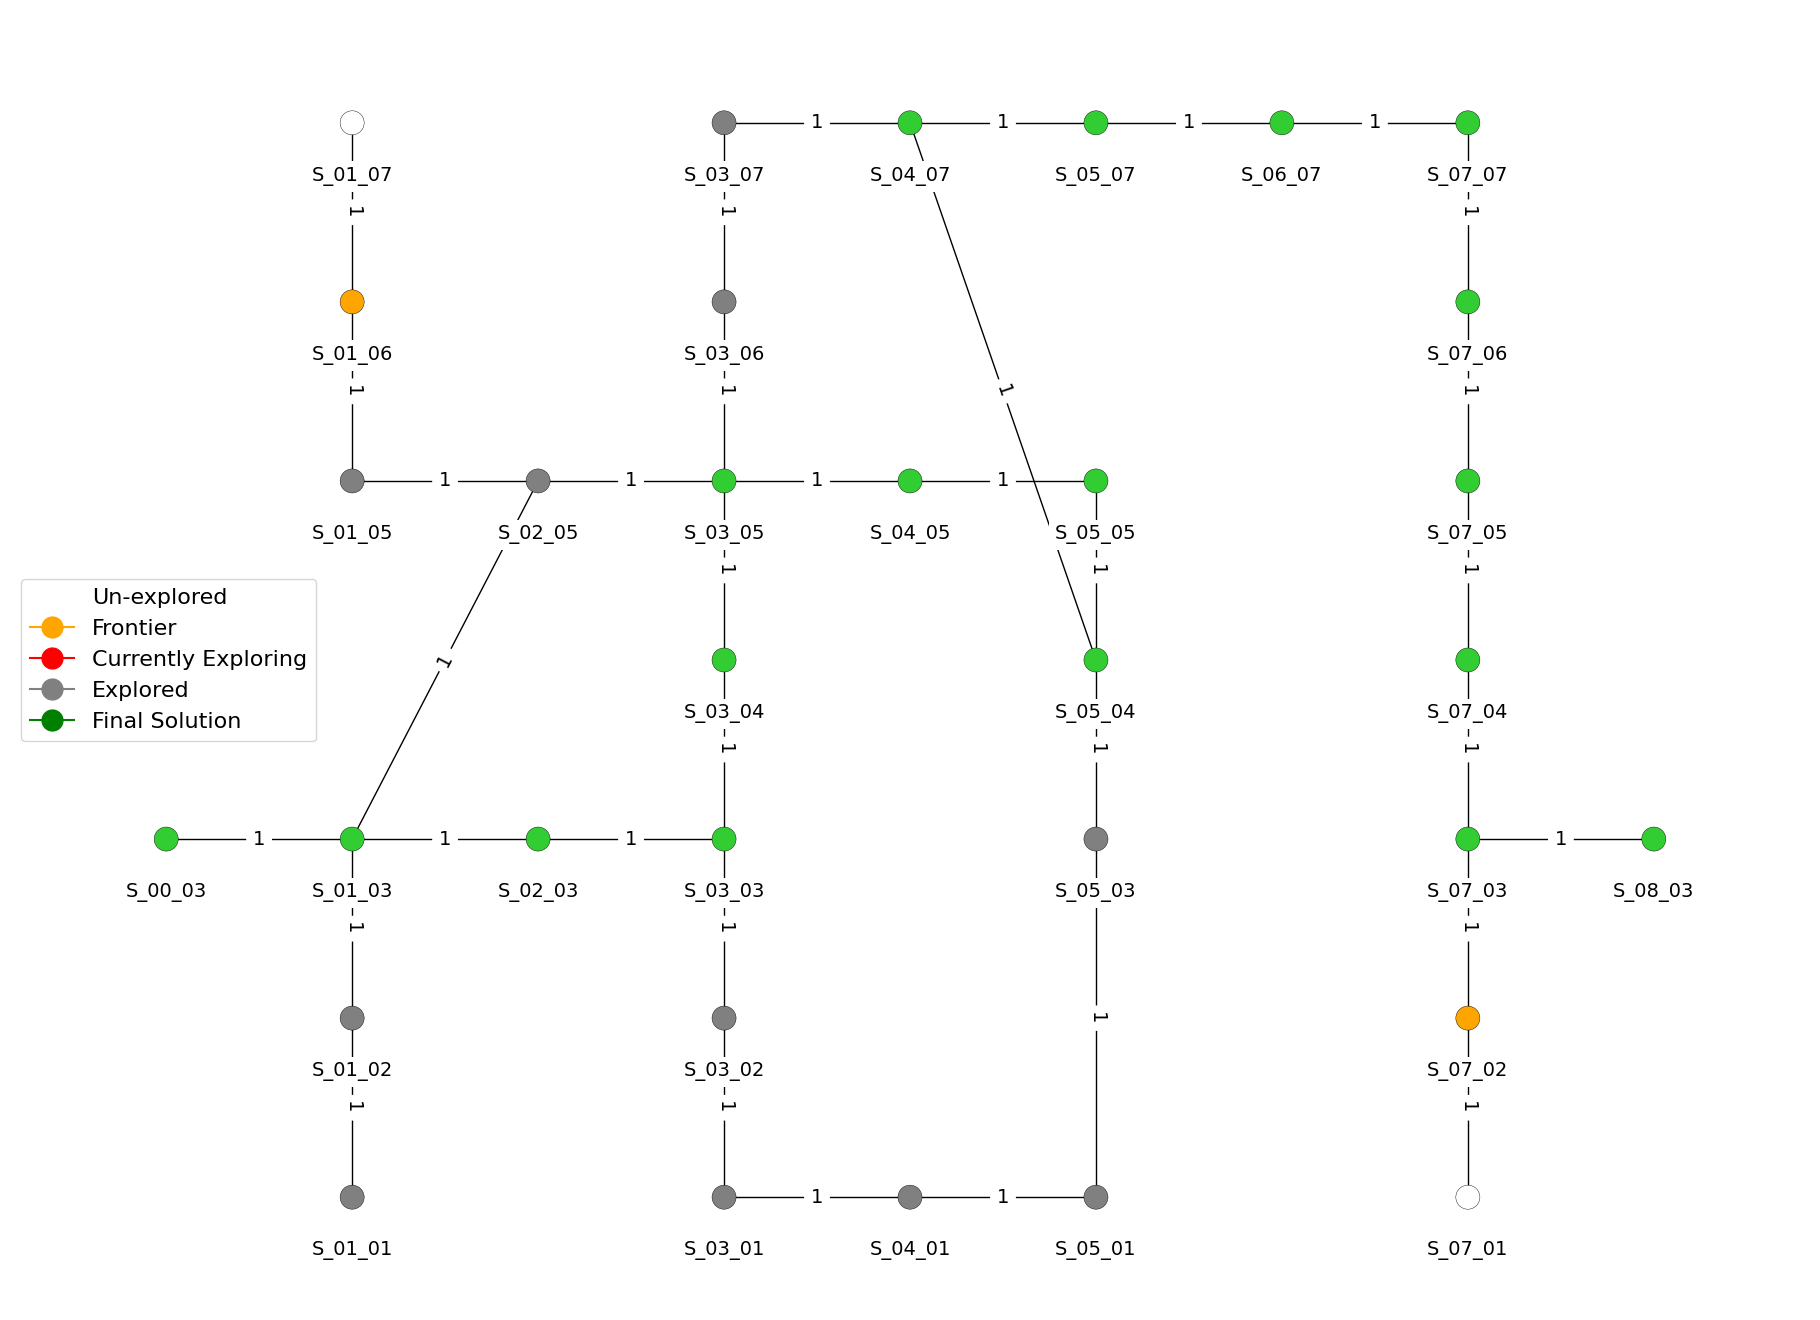

In [40]:
final_maze_graph_data = dict(maze_graph_data)
final_maze_graph_data["node_colors"] = all_node_colors[-1]

show_map(final_maze_graph_data)

In [41]:
do_full_visualization = False
if do_full_visualization:     
    # WARNING the FULL visualisation might not work very well on some computers due to 
    # the large graph and the many iterations required.The visualisaiton will 
    # typically compute the solution and do the plotting at the end - and it often takes a long time ...
    #
    print("::: Full Visualization ::::")
    maze_problem.verbose = False
    all_node_colors = []        
    display_visual(maze_graph_data, user_input=False, 
               algorithm=my_A_star_solver, 
               problem=maze_problem)
    maze_problem.verbose = True

### Analysis

**I think the problem right now is that I am not updating my h function once I get to know a wormhole's exit.**

Apparently, the solution may not be optimal

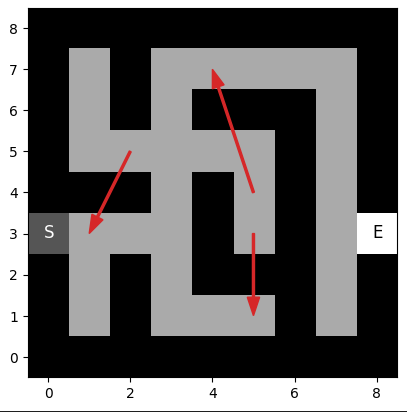

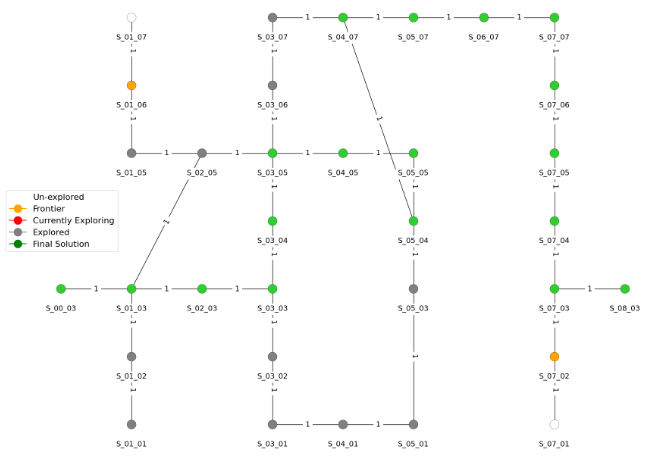

## Some other ideas

### Solve using the original A-star

The cells below copy the A* implementation from Lab 3, using helper functions from the AIMA toolbox.


In [ ]:
def my_best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = sch.memoize(f, 'f')
    node = sch.Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "limegreen"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = sch.PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "limegreen"
            node_colors[problem.initial] = "limegreen"
            for extra_node in node.solution():
                node_colors[extra_node] = "limegreen"  
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None


In [ ]:
def my_astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    h = sch.memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = my_best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

### Define the problem using the AIMA toolbox

According to the current setup...
- Cost function f = Accumulated path length, with each step uniformly assigned length 1 (wormholes included)
- Heuristic function h = Euclidian straight-line distance to the maze exit

However, to better represent the estimated remaining distance to the goal, it might be better to use a different distance metric: the sum $|x_{goal}-x| + |y_{goal}-y|$ of the vertical and horizontal distances.

In [42]:
class SquareAngleDistanceGraphProblem(sch.GraphProblem):
    """The problem of searching a graph from one node to another."""

    def __init__(self, *args, verbose=False):
        super().__init__(*args)
        self.verbose = verbose

    def h(self, node):
        """The sum of the horizontal and vertical distance to the goal"""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                state_position = np.array(locs[node])
            else:
                state_position = np.array(locs[node.state])
            goal_position = np.array(locs[self.goal])
            if self.verbose: 
                print("State position", state_position)
                print("Distance to the goal", int( np.sum( np.abs( goal_position - state_position) ) ))
            return int( np.sum( np.abs( goal_position - state_position) ) )
        else:
            return sch.infinity